# Initialization

In [39]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
import itertools
import time
import urllib
np.random.seed(1234)
%matplotlib inline
import progressbar

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.svm import  LinearSVC
from sklearn.utils import shuffle

In [41]:
import nltk
from nltk import corpus
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('names')
nltk.download('words')
nltk.download('wordnet')




[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 20newsgroups Acquiring


Approximately 20,000 records across 20 online newsgroups.Headers,signature blocks and quatations blocks are removed due to their providance of clues for topic classiciation.

In [42]:
news_train = fetch_20newsgroups(subset='train',remove=(['headers','footers','quotes']))
news_test = fetch_20newsgroups(subset='test',remove=(['headers','footers','quotes']))

The targets are categorized into 20 different newsgroups/topics.

In [43]:
print(news_train.target_names)
print(news_test.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Target: Integer index of the category.

In [44]:
print(news_train.target)
print(news_test.target)

[7 4 4 ... 3 1 8]
[ 7  5  0 ...  9  6 15]


Check number of cases

In [45]:
print(len(news_train.data))
print(len(news_test.data))

11314
7532


Check number of features

In [46]:
vectorizer = CountVectorizer(lowercase=True,stop_words='english')
news_train_vector = vectorizer.fit_transform(news_train.data)
print(news_train_vector.shape)

(11314, 101322)


# 20newsgroups Visualization

Visualization of the distrubution of topics: A nearly uniform class distribution hence no need to worry under-reprented or over-reprented topics.

In [ ]:
sns.histplot(news_train.target)
#sns.histplot(news_test.target,color = "skyblue")
plt.show()

Visualzationa and Preprocessing using 300 most indicative features. Convert test data into numerical features using bages of words representation. Using occurance of words.

In [ ]:
vectorizer = CountVectorizer(lowercase=True,stop_words='english',max_features=300)
news_train_vector = vectorizer.fit_transform(news_train.data)
#news_test_vector = vectorizer.transform(news_test.data).toarray()
sns.histplot(np.log(news_train_vector.toarray().sum(axis=0)))
#sns.histplot(np.log(news_test_vector.toarray().sum(axis=0)),color='skyblue')
plt.xlabel('Log Count')
plt.ylabel('Frequency')
plt.title('Distrubution of 300 dominant Feature Count')

Check the 300 most indicative features and several words should be filted acorrding to following notes.

Note1: digits.

Note2: singular and plural form of same words. E.x.book,books

Note3: Derivative words and words of different tense. E.x.write,written,try,trying

Note4: Names. E.x. John


In [ ]:
print(vectorizer.get_feature_names_out())

# 20newsgroups Preprocessing


Apply filtering according to above notes.

In [47]:
def letters(astr):
  return astr.isalpha()

In [48]:
nnames = set(corpus.names.words())
lemmatizer = WordNetLemmatizer()

news_train_filtered = []
for record in news_train.data:
  news_train_filtered.append(' '.join([lemmatizer.lemmatize(word.lower())
              for word in record.split()
              if letters(word) and word not in nnames]))
  

news_test_filtered = []
for record in news_test.data:
  news_test_filtered.append(' '.join([lemmatizer.lemmatize(word.lower())
              for word in record.split()
              if letters(word) and word not in nnames]))

Print number of filtered features.

In [49]:
vectorizer = CountVectorizer(stop_words='english')
news_train_vector = vectorizer.fit_transform(news_train_filtered)
news_test_vector = vectorizer.transform(news_test_filtered)
print(news_train_vector.shape)

(11314, 40455)


Further reduce the dimention of features using variance threshold.

In [50]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
news_train_var = selector.fit_transform(news_train_vector)
news_test_var = selector.transform(news_test_vector)
print(news_train_var.shape)

(11314, 2413)


Random features(same number)

In [51]:
col_rand_array = np.arange(news_train_var.shape[1])
np.random.shuffle(col_rand_array)
news_train_randomvar=news_train_vector[:,col_rand_array[0:news_train_var.shape[1]]]
news_test_randomvar=news_test_vector[:,col_rand_array[0:news_test_var.shape[1]]]
print(news_train_randomvar.shape)

(11314, 2413)


Text(0.5, 1.0, 'Distrubution of Feature Count')

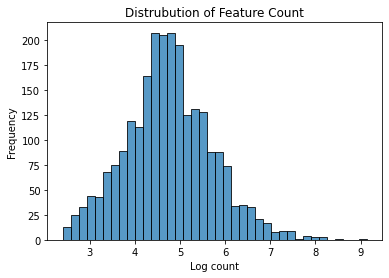

In [52]:
sns.histplot(np.log(news_train_var.toarray().sum(axis=0)))
#sns.histplot(np.log(news_test_vector.toarray().sum(axis=0)),color='skyblue')
plt.xlabel('Log count')
plt.ylabel('Frequency')
plt.title('Distrubution of Feature Count')


Text(0.5, 1.0, 'Distrubution of Random Feature Count')

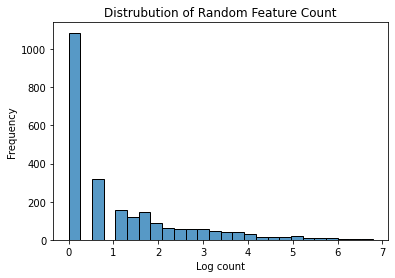

In [53]:
sns.histplot(np.log(news_train_randomvar.toarray().sum(axis=0)))
#sns.histplot(np.log(news_test_vector.toarray().sum(axis=0)),color='skyblue')
plt.xlabel('Log count')
plt.ylabel('Frequency')
plt.title('Distrubution of Random Feature Count')


Transfrom from occurance to frequencies

In [54]:

tf_transformer = TfidfTransformer(use_idf=True,smooth_idf=True).fit(news_train_var)
news_train_tfidf= tf_transformer.transform(news_train_var).toarray()
news_test_tfidf = tf_transformer.transform(news_test_var).toarray()


In [55]:
tf_transformer_random = TfidfTransformer(use_idf=True,smooth_idf=True).fit(news_train_randomvar)
news_train_tfidf_random= tf_transformer_random.transform(news_train_randomvar).toarray()
news_test_tfidf_random = tf_transformer_random.transform(news_test_randomvar).toarray()

Text(0.5, 1.0, 'Distrubution of Feature Tf-idf')

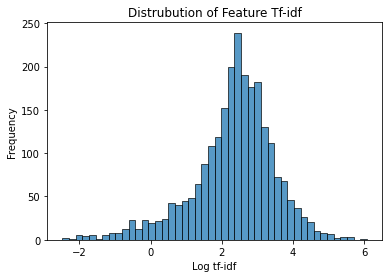

In [56]:
sns.histplot(np.log(news_train_tfidf.sum(axis=0)))
#sns.histplot(np.log(news_test_vector.toarray().sum(axis=0)),color='skyblue')
plt.xlabel('Log tf-idf')
plt.ylabel('Frequency')
plt.title('Distrubution of Feature Tf-idf')

Text(0.5, 1.0, 'Distrubution of Random Feature Tf-idf')

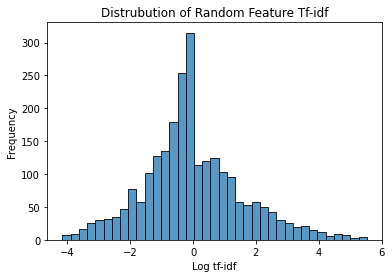

In [57]:
sns.histplot(np.log(news_train_tfidf_random.sum(axis=0)))
#sns.histplot(np.log(news_test_vector.toarray().sum(axis=0)),color='skyblue')
plt.xlabel('Log tf-idf')
plt.ylabel('Frequency')
plt.title('Distrubution of Random Feature Tf-idf')

# 140sentiment Acquiring

Load google drive

In [58]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read data from google drive and attribute to target and text

In [59]:
cols = ['sentiment','id','date','query_string','user','text']

senti_train_data=pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',low_memory=False,encoding='latin-1',header=None,names=cols,engine='c')
senti_train_data['sentiment']=(senti_train_data['sentiment']/4).astype(int)
print(senti_train_data)
senti_test_data=pd.read_csv('/content/drive/MyDrive/new_testdata.manual.2009.06.14.csv',names=cols)
senti_test_data['sentiment']=(senti_test_data['sentiment']/4).astype(int)
print(senti_test_data)


         sentiment          id                          date query_string  \
0                0  1467810369  Mon Apr 06 22:19:45 PDT 2009     NO_QUERY   
1                0  1467810672  Mon Apr 06 22:19:49 PDT 2009     NO_QUERY   
2                0  1467810917  Mon Apr 06 22:19:53 PDT 2009     NO_QUERY   
3                0  1467811184  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   
4                0  1467811193  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   
...            ...         ...                           ...          ...   
1599995          1  2193601966  Tue Jun 16 08:40:49 PDT 2009     NO_QUERY   
1599996          1  2193601969  Tue Jun 16 08:40:49 PDT 2009     NO_QUERY   
1599997          1  2193601991  Tue Jun 16 08:40:49 PDT 2009     NO_QUERY   
1599998          1  2193602064  Tue Jun 16 08:40:49 PDT 2009     NO_QUERY   
1599999          1  2193602129  Tue Jun 16 08:40:50 PDT 2009     NO_QUERY   

                    user                                               text

Drop other data

In [60]:
senti_train_data=senti_train_data.drop(['id','date','query_string','user'],axis=1,inplace=False)
senti_test_data=senti_test_data.drop(['id','date','query_string','user'],axis=1,inplace=False)
senti_train_data = pd.concat([senti_train_data[0:50000],senti_train_data[800000:850000]])
senti_train_data = shuffle(senti_train_data)
print(senti_train_data)
print(senti_test_data)


        sentiment                                               text
829283          1  Last song of the night: That's what you get by...
809952          1  @rivensky Haha. Well I have more but I don't h...
803303          1  Still no-one in reception.  Ach well more inte...
844747          1  @johncmayer I made you an iMix John,  I hope y...
810581          1              @sleep2dream GO BB GO.  you got this.
...           ...                                                ...
826058          1  Hmmm...leave some feedback on my blog whathave...
827097          1  @thebookangel you are welcome... have a great ...
805177          1  @JohnFletcher yea I'll meet you in the town ce...
830263          1  @Meranda_Panda Thanks for 2 nite. Had an AWESO...
812825          1  @morganholzer (Earmuffs @sprizzle) You can't p...

[100000 rows x 2 columns]
     sentiment                                               text
0            1  @stellargirl I loooooooovvvvvveee my Kindle2. ...
1            

Divide data in to target and text

In [61]:
senti_train_target = senti_train_data['sentiment']
senti_train_text = senti_train_data['text']
senti_test_target = senti_train_data['sentiment']
senti_test_text = senti_train_data['text']

# 140sentiment Visualization



Training data sentiment distrubution is equally partitioned. 

In [ ]:
senti_train_data.sentiment.value_counts()

test data distribution

In [ ]:
senti_test_data.sentiment.value_counts()

Observe the text length distrubution, some of them exceends the length limits.

In [ ]:
senti_train_data['length']=[len(text) for text in senti_train_data.text]
print(senti_train_data)
plt.hist(senti_train_data['length'])
plt.show()

Observe that there are some invalid symbol/characters which may due to failed encoding conversion. (emoji, html )

In [ ]:
senti_train_data[senti_train_data.length > 140].head(20)

# 140sentiment Preprocessing

By observing the invalid symbols/characters from visualizaiton, it is decided to further remove non-english words besides the filter process which was done for 20newsgrousp (remove name, digits and similar words)

In [62]:
ewords = set(corpus.words.words())
nnames = set(corpus.names.words())
lemmatizer = WordNetLemmatizer()


senti_train_filtered = []
for record in senti_train_text:
  senti_train_filtered.append(' '.join([lemmatizer.lemmatize(word.lower())
              for word in record.split()
              if word.isalpha() and word.lower() in ewords and word not in nnames]))
  

senti_test_filtered = []
for record in senti_test_text:
  senti_test_filtered.append(' '.join([lemmatizer.lemmatize(word.lower())
              for word in record.split()
              if word.isalpha() and word.lower() in ewords and word not in nnames]))

Original feature 12511

In [63]:
vectorizer = CountVectorizer(stop_words='english')
senti_train_vector = vectorizer.fit_transform(senti_train_filtered)
senti_test_vector = vectorizer.transform(senti_test_filtered)
print(senti_train_vector.shape)

(100000, 12511)


Selected feature(after variancethreshold=0.001)

In [64]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.001)
senti_train_var = selector.fit_transform(senti_train_vector)
senti_test_var = selector.transform(senti_test_vector)
print(senti_train_var.shape)

(100000, 563)


Random features(same number)

In [65]:
col_rand_array = np.arange(senti_train_vector.shape[1])
np.random.shuffle(col_rand_array)
senti_train_randomvar=senti_train_vector[:,col_rand_array[0:senti_train_var.shape[1]]]
senti_test_randomvar=senti_test_vector[:,col_rand_array[0:senti_test_var.shape[1]]]
print(senti_train_randomvar.shape)

(100000, 563)


Distribution of feature count

Text(0.5, 1.0, 'Distrubution of Feature Count')

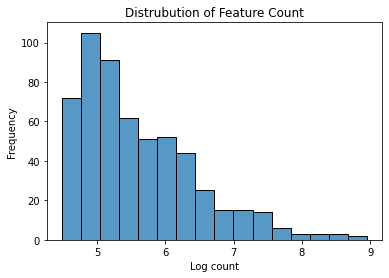

In [66]:
sns.histplot(np.log(senti_train_var.toarray().sum(axis=0)))
#sns.histplot(np.log(news_test_vector.toarray().sum(axis=0)),color='skyblue')
plt.xlabel('Log count')
plt.ylabel('Frequency')
plt.title('Distrubution of Feature Count')


Distribution of same number random feature count

Text(0.5, 1.0, 'Distrubution of Random Feature Count')

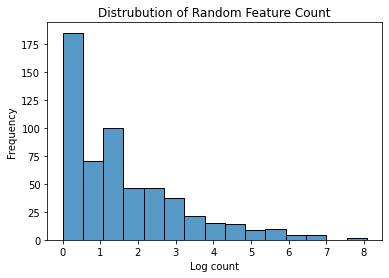

In [67]:
sns.histplot(np.log(senti_train_randomvar.toarray().sum(axis=0)))
plt.xlabel('Log count')
plt.ylabel('Frequency')
plt.title('Distrubution of Random Feature Count')

In [68]:
tf_transformer = TfidfTransformer(use_idf=True,smooth_idf=True).fit(senti_train_var)
senti_train_tfidf= tf_transformer.transform(senti_train_var).toarray()
senti_test_tfidf = tf_transformer.transform(senti_test_var).toarray()


Text(0.5, 1.0, 'Distrubution of Feature Tf-idf')

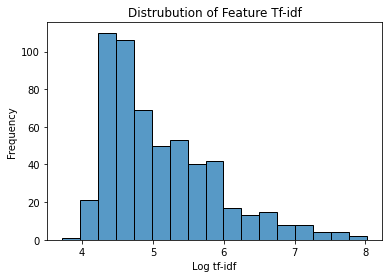

In [69]:
sns.histplot(np.log(senti_train_tfidf.sum(axis=0)))
#sns.histplot(np.log(news_test_vector.toarray().sum(axis=0)),color='skyblue')
plt.xlabel('Log tf-idf')
plt.ylabel('Frequency')
plt.title('Distrubution of Feature Tf-idf')

In [70]:
tf_transformer_random = TfidfTransformer(use_idf=True,smooth_idf=True).fit(senti_train_randomvar)
senti_train_tfidf_random= tf_transformer.transform(senti_train_randomvar).toarray()
senti_test_tfidf_random = tf_transformer.transform(senti_test_randomvar).toarray()

Text(0.5, 1.0, 'Distrubution of Random Feature Tf-idf')

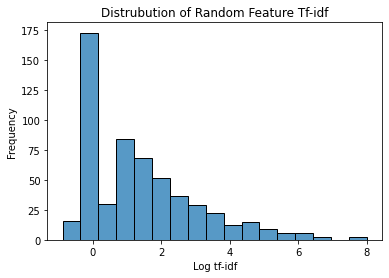

In [71]:
sns.histplot(np.log(senti_train_tfidf_random.sum(axis=0)))
plt.xlabel('Log tf-idf')
plt.ylabel('Frequency')
plt.title('Distrubution of Random Feature Tf-idf')

# Gaussian Naive Bayes

In [72]:

class GaussianNaiveBayes:
    
    def __init__(self):
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
            x_c = x[y == c]                           #slice all the elements from class c
            Nc[c] = x_c.shape[0]                      #get number of elements of class c
            mu[c,:] = np.mean(x_c,0) + 0.01                 #mean of features of class c
            sigma[c,:] = np.std(x_c, 0) +0.01           #std of features of class c
            
        self.mu = mu                                  # C x D
        self.sigma = sigma                            # C x D
        self.pi = (Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

In [73]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    Nt, D = xt.shape
    # for numerical stability we work in the log domain
    # we add a dimension because this is added to the log-likelihood matrix 
    # that assigns a likelihood for each class (C) to each test point, and so it is C x N
    log_prior = np.log(self.pi)[:, None]
    # logarithm of the likelihood term for Gaussian 
    # the first two terms are the logarithm of the normalization term in the Gaussian and the final term is the exponent in the Gaussian. 
    # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation. 
    # The reason is that sigma and mu are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
    log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
    # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
    log_likelihood = np.sum(log_likelihood, axis=2)
    # posterior calculation
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return posterior.T                                                  # dimension N x C

GaussianNaiveBayes.predict = predict

# Multinomial Naive Bayes

In [74]:
class MultiNaiveBayes:
    
    def __init__(self,alpha):
        self.alpha = alpha
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        theta = np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
          x_c = x_train[y_train == c]                #slice all the elements from class c
          Nc[c] = x_c.shape[0]
          for d in range(D):
            theta[c,d]=(np.sum(x_c[:,d])+self.alpha)/(np.sum(x_c)+(self.alpha*D))      #Laplace smoothing using alhpha_theta = 1
            
        self.theta = theta
        self.pi=(Nc+1)/(N+C)                       #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

In [75]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    
    Nt, D = xt.shape
    # for numerical stability we work in the log domain
    # we add a dimension because this is added to the log-likelihood matrix 
    # that assigns a likelihood for each class (C) to each test point, and so it is C x N
    log_prior = np.log(self.pi)[:, None]
    # logarithm of the likelihood term for Multinomial
    # the first two terms are the logarithm of the normalization term in the Multinomial and the final term is the exponent in the Multinomail. 
    # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation. 
    # The reason is that theta are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
    log_likelihood = np.log(np.power(self.theta[:,None,:],xt[None,:,:])) 
    # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
    log_likelihood = np.sum(log_likelihood, axis=2)
    # posterior calculation
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return posterior.T                           # dimension N x C

MultiNaiveBayes.predict = predict

# Evaluation Functions

Take true label and target labels, output accuracy.

In [85]:
 def evaluate_acc(y_output,y_target):
   accuracy = np.sum(y_output == y_target)/y_output.shape[0]
   return accuracy

Take training data as inputs and splits into n folds.

In [86]:
def cross_validate_split(n, n_folds):
  n_val = n // n_folds
  inds = np.random.permutation(n)
  inds = []
  for f in range(n_folds):
    tr_inds = []
    val_inds = list(range(f*n_val, (f+1)*n_val))
    if f > 0:
      tr_inds = list(range(f*n_val))
    if f < n_folds - 1:
      tr_inds = tr_inds + list(range((f+1)*n_val,n))
    yield tr_inds, val_inds

In [87]:
def cross_validate_mnb(num_folds,x,y):
  (num_instances,num_features),num_classes = x.shape, np.max(y)+1
  alpha_list = [0.001,0.01,0.1,0,1,10]
  
  acc_valid = np.zeros((len(alpha_list), num_folds))
  for i,a in enumerate(alpha_list):
    mnb = MultiNaiveBayes(alpha=a)
    for f, (tr,val) in enumerate(cross_validate_split(num_instances,num_folds)):
      probs_test = mnb.fit(x[tr],y[tr]).predict(x[val])
      y_pred = np.argmax(probs_test,1)
      acc_valid[i,f] = np.sum(y_pred == y[val])/y[val].shape[0]

  for i in range(len(alpha_list)):
    print('Using alpha:' + str(alpha_list[i]) +' '+ 'Mean Accuracy:' + str(np.mean(acc_valid[i])) + ' '+'Std:' + str(np.std(acc_valid[i])))


  plt.errorbar(alpha_list, np.mean(acc_valid, axis=1), np.std(acc_valid, axis=1), label='validation')
  plt.legend()
  plt.xlabel('a(smoothing factor)')
  plt.ylabel('mean accuracy')
  plt.show()    
    

In [88]:
def cross_validate_lr(num_folds,x,y):
  (num_instances,num_features),num_classes = x.shape, np.max(y)+1
  penalty = ['l2','none'] 
  max_iter = [1000,5000,10000]
  accuracy = []
  for iter in max_iter:
    acc_valid = np.zeros((len(penalty), num_folds))
    for i, p in enumerate(penalty):
      lr = LogisticRegression(penalty=p,max_iter=iter)
      for f, (tr,val) in enumerate(cross_validate_split(num_instances,num_folds)):
        probs_test = lr.fit(x[tr],y[tr]).predict(x[val])
        y_pred = np.argmax(probs_test)
        acc_valid[i,f] = np.sum(y_pred == y[val])/y[val].shape[0]
    accuracy.append(acc_valid)

  plt.plot(penalty, np.mean(accuracy[0],axis=1), label = '1000 max_iter')
  plt.plot(penalty, np.mean(accuracy[1],axis=1), label = '5000 max_iter')
  plt.plot(penalty, np.mean(accuracy[1],axis=1), label = '10000 max_iter')
  plt.legend()
  plt.xticks(range(len(penalty)),penalty)
  plt.xlabel('penalty')
  plt.ylabel('Mean accuracy')
  plt.show()

# 20newsgroups Parameter Tuning


In [ ]:
x_train, x_test, y_train, y_test = news_train_tfidf,news_test_tfidf,news_train.target,news_test.target

In [ ]:
cross_validate_mnb(5,x_train,y_train)

In [ ]:

cross_validate_lr(5,x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# 20newsgroups Experiment

In [80]:
x_train, x_test, y_train, y_test = news_train_tfidf,news_test_tfidf,news_train.target,news_test.target

In [ ]:
x_train_random, x_test_random, y_train_random, y_test_random = news_train_tfidf_random,news_test_tfidf_random,news_train.target,news_test.target

MultiNaiveBayes:

In [81]:

mnb = MultiNaiveBayes(alpha=0.001)
mnb.fit(x_train, y_train)
y_prob = mnb.predict(x_test)
y_pred = np.argmax(y_prob, 1)
accuracy = evaluate_acc(y_pred,y_test)
print(y_pred)
print(f'test accuracy: {accuracy}')


[ 7  5 10 ...  9 12 15]
test accuracy: 0.5511152416356877


In [ ]:

mnbmetrics = metrics.confusion_matrix(y_pred,y_test)
#print(mnbmetrics)

In [ ]:
print('Multinomial Naive Bayes Classification Error:', 1-metrics.accuracy_score(y_pred,y_test))
print('Multinomial Naive Bayes Sensitivity:', metrics.recall_score(y_pred,y_test,average='weighted'))
print('Multinomial Naive Bayes Precision:', metrics.precision_score(y_pred,y_test,average='weighted'))

Multinomial Naive Bayes Classification Error: 0.4488847583643123
Multinomial Naive Bayes Sensitivity: 0.5511152416356877
Multinomial Naive Bayes Precision: 0.5814190996125577


In [ ]:
mnb = MultiNaiveBayes(alpha=0.001)
mnb.fit(x_train_random, y_train_random)
y_prob = mnb.predict(x_test_random)
y_pred = np.argmax(y_prob, 1)
accuracy = evaluate_acc(y_pred,y_test_random)
print(y_pred)
print(f'test (random feature) accuracy: {accuracy}')

[10  5 10 ...  3 10 10]
test (random feature) accuracy: 0.06386086032926182


In [ ]:
gnb = GaussianNaiveBayes()
gnb.fit(x_train, y_train)
y_prob = gnb.predict(x_test)
y_pred = np.argmax(y_prob, 1)
accuracy = evaluate_acc(y_pred,y_test)
print(y_pred)
print(f'test accuracy: {accuracy}')

[ 7  5  9 ... 11  6  0]
test accuracy: 0.4840679766330324


In [ ]:
gnb = GaussianNaiveBayes()
gnb.fit(x_train_random, y_train_random)
y_prob = gnb.predict(x_test_random)
y_pred = np.argmax(y_prob, 1)
accuracy = evaluate_acc(y_pred,y_test_random)
print(y_pred)
print(f'test (random feature) accuracy: {accuracy}')

[ 2  7  2 ... 15  2  2]
test (random feature) accuracy: 0.18228890069038767


Further analysis using confusion matrix

LogisticRegression:

In [82]:
lr = LogisticRegression(solver='lbfgs',max_iter=1000)
lr.fit(x_train, y_train)
y_prob = lr.predict_log_proba(x_test)
y_pred = np.argmax(y_prob, 1)
accuracy = np.mean(y_pred == news_test.target)
print(y_pred)
print(f'test accuracy: {accuracy}')

[15  1  8 ... 10 12 15]
test accuracy: 0.5658523632501328


In [ ]:
lrmetrics = metrics.confusion_matrix(y_pred,y_test)
#print(lrmetrics)

In [ ]:
print('Logistic Regression Classification Error:', 1-metrics.accuracy_score(y_pred,y_test))
print('Logistic Regression Sensitivity:', metrics.recall_score(y_pred,y_test,average='weighted'))
print('Logistic Regression Precision:', metrics.precision_score(y_pred,y_test,average='weighted'))

Logistic Regression Classification Error: 0.4341476367498672
Logistic Regression Sensitivity: 0.5658523632501328
Logistic Regression Precision: 0.5806275333517751


In [ ]:
lr = LogisticRegression(solver='lbfgs',max_iter=1000)
lr.fit(x_train_random, y_train_random)
y_prob = lr.predict_log_proba(x_test_random)
y_pred = np.argmax(y_prob, 1)
accuracy = np.mean(y_pred == news_test.target)
print(y_pred)
print(f'test (random feature) accuracy: {accuracy}')

[8 7 8 ... 0 8 8]
test (random feature) accuracy: 0.21548061603823684


# 140sentiment Parameter Tuning

In [ ]:
x_train, x_test, y_train, y_test = senti_train_tfidf,senti_test_tfidf,senti_train_target.to_numpy(),senti_test_target

In [ ]:
cross_validate_mnb(5,x_train,y_train)

In [ ]:
cross_validate_lr(5,x_train,y_train)

# 140sentiment Experiment

In [ ]:
x_train, x_test, y_train, y_test = senti_train_tfidf,senti_test_tfidf,senti_train_target,senti_test_target

In [ ]:
x_train_random, x_test_random, y_train_random, y_test_random = senti_train_tfidf_random,senti_test_tfidf_random,senti_train_target,senti_test_target

mnb trained with 140sentiment dataset with selected features.

In [ ]:
mnb = MultiNaiveBayes(alpha=0.001)
mnb.fit(x_train, y_train)
y_prob = mnb.predict(x_test)
y_pred = np.argmax(y_prob, 1)
accuracy = evaluate_acc(y_pred,y_test)
print(y_pred)
print(f'test accuracy: {accuracy}')


mnb trained with 140sentiment dataset with random features.

In [ ]:
mnbmetrics = metrics.confusion_matrix(y_pred,y_test)
#print(mnbmetrics)
print('Multinomial Naive Bayes Classification Error:', 1-metrics.accuracy_score(y_pred,y_test))
print('Multinomial Naive Bayes Sensitivity:', metrics.recall_score(y_pred,y_test,average='weighted'))
print('Multinomial Naive Bayes Precision:', metrics.precision_score(y_pred,y_test,average='weighted'))

In [ ]:
mnb = MultiNaiveBayes(alpha=0.001)
mnb.fit(x_train_random, y_train_random)
y_prob = mnb.predict(x_test_random)
y_pred = np.argmax(y_prob, 1)
accuracy = evaluate_acc(y_pred,y_test_random)
print(y_pred)
print(f'test (random feature) accuracy: {accuracy}')

gnb trained with 140sentiment dataset with selected features.

In [ ]:
gnb = GaussianNaiveBayes()
gnb.fit(x_train, y_train)
y_prob = gnb.predict(x_test)
y_pred = np.argmax(y_prob, 1)
accuracy = evaluate_acc(y_pred,y_test)
print(y_pred)
print(f'test accuracy: {accuracy}')

In [ ]:
gnb = GaussianNaiveBayes()
gnb.fit(x_train_random, y_train_random)
y_prob = gnb.predict(x_test_random)
y_pred = np.argmax(y_prob, 1)
accuracy = evaluate_acc(y_pred,y_test_random)
print(y_pred)
print(f'test(random feature) accuracy: {accuracy}')

In [ ]:
lr = LogisticRegression(solver='lbfgs',max_iter=1000)
lr.fit(x_train, y_train)
y_prob = lr.predict_log_proba(x_test)
y_pred = np.argmax(y_prob, 1)
accuracy = np.mean(y_pred == y_test)
print(y_pred)
print(f'test accuracy: {accuracy}')

In [ ]:
lrmetrics = metrics.confusion_matrix(y_pred,y_test)
#print(lrmetrics)
print('Logistic Regression Classification Error:', 1-metrics.accuracy_score(y_pred,y_test))
print('Logistic Regression Sensitivity:', metrics.recall_score(y_pred,y_test,average='weighted'))
print('Logistic Regression Precision:', metrics.precision_score(y_pred,y_test,average='weighted'))


In [ ]:
lr = LogisticRegression(solver='lbfgs',max_iter=1000)
lr.fit(x_train, y_train)
y_prob = lr.predict_log_proba(x_test_random)
y_pred = np.argmax(y_prob, 1)
accuracy = np.mean(y_pred == y_test_random)
print(y_pred)
print(f'test (random feature) accuracy: {accuracy}')

# 20newsgroups Random data selection

In [ ]:
def random_data(x,y,n):
  (num_instances,num_features),num_classes = x.shape, np.max(y)
  n_select = int(num_instances * n)
  inds = np.random.permutation(num_instances)
  x_select,y_select = x[inds[:n_select]],y[inds[:n_select]]
  return x_select,y_select

In [ ]:
x_test, y_test = news_test_tfidf,news_test.target
size_list = [0.2,0.4,0.6,0.8]

acc_lr = []
acc_mnb = []

for s in size_list:
  x_train,y_train = random_data(news_train_tfidf,news_train.target,s)

  lr = LogisticRegression(max_iter=1000)
  lr.fit(x_train, y_train)
  y_prob = lr.predict_log_proba(x_test)
  y_pred = np.argmax(y_prob, 1)
  acc_lr.append(evaluate_acc(y_pred,y_test))

  mnb = MultiNaiveBayes(alpha=1)
  y_prob = mnb.fit(x_train, y_train).predict(x_test)
  y_pred = np.argmax(y_prob, 1)
  acc_mnb.append(evaluate_acc(y_pred,y_test))


plt.plot(size_list, acc_mnb, label = 'mnb')
plt.plot(size_list, acc_lr, label = 'lr')
plt.legend()
plt.xlabel('Dataset size')
plt.ylabel('Accuracy')
plt.show()



# 140sentiment Random data selection

In [ ]:
def random_data(x,y,n):
  y=y.to_numpy()
  num_instances,num_features = x.shape
  n_select = int(num_instances * n)
  inds = np.random.permutation(num_instances)
  x_select,y_select = x[inds[:n_select]],y[inds[:n_select]]
  return x_select,y_select

In [ ]:
print(type(senti_train_target))

In [ ]:
x_test, y_test = senti_test_tfidf,senti_test_target
size_list = [0.2,0.4,0.6,0.8]

acc_lr = []
acc_mnb = []

for s in size_list:
  x_train,y_train = random_data(senti_train_tfidf,senti_train_target,s)

  lr = LogisticRegression(max_iter=1000)
  lr.fit(x_train, y_train)
  y_prob = lr.predict_log_proba(x_test)
  y_pred = np.argmax(y_prob, 1)
  acc_lr.append(evaluate_acc(y_pred,y_test))

  mnb = MultiNaiveBayes(alpha=1)
  y_prob = mnb.fit(x_train, y_train).predict(x_test)
  y_pred = np.argmax(y_prob, 1)
  acc_mnb.append(evaluate_acc(y_pred,y_test))


print(acc_lr)

plt.plot(size_list, acc_mnb, label = 'mnb')
plt.plot(size_list, acc_lr, label = 'lr')
plt.legend()
plt.xlabel('Dataset size')
plt.ylabel('Accuracy')
plt.show()
